#1. Ekstraksi Data Audio

In [ ]:
import os
import zipfile
import shutil

# Ekstrak Audio
if os.path.exists('/content/Audio.zip'):
    print("⏳ Mengekstrak Audio.zip...")
    with zipfile.ZipFile('/content/Audio.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/dataset_mirex')
    print("✅ Audio siap.")

PATH_AUDIO = '/content/dataset_mirex/Audio'
PATH_BAT = '/content/split-by-categories-lyrics.bat'

⏳ Mengekstrak Audio.zip...
✅ Audio siap.


#2. Parsing Label & Pembuatan Master Data

In [ ]:
import pandas as pd
import re

# Parsing Label dari .bat
label_data = []
pattern = re.compile(r'move (\d+)\.txt "([^\\]+)\\.*')
with open(PATH_BAT, 'r') as f:
    for line in f:
        match = pattern.search(line)
        if match:
            label_data.append({'file_id': match.group(1), 'emotion': match.group(2)})

data_df = pd.DataFrame(label_data)
unique_labels = sorted(data_df['emotion'].unique())
label_map = {label: i for i, label in enumerate(unique_labels)}
data_df['label_id'] = data_df['emotion'].map(label_map)

print(f"✅ Total Master Data: {len(data_df)} lagu.")

✅ Total Master Data: 903 lagu.


#3. Sinkronisasi ID Audio dengan Hasil Lirik

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# 1. Baca ID Master dari hasil lirik
df_lyric_ref = pd.read_csv('/content/lyric_prob.csv')
lyric_test_ids = df_lyric_ref['id'].astype(str).tolist()

# 2. Pastikan file_id di data_df utama bertipe string
data_df['file_id'] = data_df['file_id'].astype(str)

# 3. Pisahkan Data Train & Val secara internal
train_val_df, _ = train_test_split(
    data_df, test_size=0.2, stratify=data_df['label_id'], random_state=42
)
train_df, val_df = train_test_split(
    train_val_df, test_size=0.1, stratify=train_val_df['label_id'], random_state=42
)

# 4. SINKRONISASI DATA TEST: Paksa ID mengikuti urutan di lyric_prob.csv
test_audio_df = data_df.set_index('file_id').reindex(lyric_test_ids).reset_index()
test_audio_df = test_audio_df.rename(columns={'index': 'file_id'})

# 5. PENANGANAN ERROR NaN: Jika ada ID lirik yang tidak tercatat di label (.bat)
test_audio_df['label_id'] = test_audio_df['label_id'].fillna(-1)

# 6. Tambahkan Path Audio & Cek keberadaan file fisik (Anti-Error FileNotFound)
def get_safe_path(fid):
    path = os.path.join(PATH_AUDIO, f"{fid}.mp3")
    return path if os.path.exists(path) else None

train_df['audio_path'] = train_df['file_id'].apply(get_safe_path)
val_df['audio_path'] = val_df['file_id'].apply(get_safe_path)
test_audio_df['audio_path'] = test_audio_df['file_id'].apply(get_safe_path)

train_audio_df = train_df.dropna(subset=['audio_path']).copy()
val_audio_df = val_df.dropna(subset=['audio_path']).copy()

print(f"✅ Blok 3 Selesai.")
print(f"Jumlah Data Test Audio: {len(test_audio_df)} (Sinkron dengan Lirik)")

✅ Blok 3 Selesai.
Jumlah Data Test Audio: 77 (Sinkron dengan Lirik)


#4. Dataset & DataLoader

In [ ]:
import librosa
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['audio_path']
        label = int(row['label_id']) # Aman dari NaN karena sudah di-fill -1 di Blok 3

        target_len = 22050 * 30 # Target durasi 30 detik

        # JIKA FILE TIDAK ADA (Path None)
        if path is None:
            # Mengembalikan matriks nol (hening) agar urutan baris di CSV tidak bergeser
            # Ukuran 1292 adalah ukuran standar waktu untuk spectrogram 30 detik
            return torch.zeros((1, 128, 1292)), torch.tensor(label, dtype=torch.long)

        try:
            # Load audio
            y, sr = librosa.load(path, sr=22050, duration=30.0)

            # Standarisasi panjang (Padding jika kurang, cutting jika lebih)
            if len(y) < target_len:
                y = np.pad(y, (0, target_len - len(y)))
            else:
                y = y[:target_len]

            # Pembuatan Mel-Spectrogram
            spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            spec_db = librosa.power_to_db(spec, ref=np.max)

            # Normalisasi nilai ke range 0-1 agar model cepat belajar
            spec_norm = (spec_db - spec_db.min()) / (spec_db.max() - spec_db.min() + 1e-6)

            return torch.tensor(spec_norm).unsqueeze(0), torch.tensor(label, dtype=torch.long)

        except Exception:
            # Jika file rusak saat dibaca, kembalikan audio hening
            return torch.zeros((1, 128, 1292)), torch.tensor(label, dtype=torch.long)

# Inisialisasi DataLoader
BATCH_SIZE = 16

train_loader = DataLoader(AudioDataset(train_audio_df), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(AudioDataset(val_audio_df), batch_size=BATCH_SIZE)

# SANGAT KRUSIAL: shuffle=False untuk Test agar urutan ID tidak berantakan
test_loader = DataLoader(AudioDataset(test_audio_df), batch_size=BATCH_SIZE, shuffle=False)

print("✅ Blok 4 Selesai. DataLoader Audio siap digunakan.")

✅ Blok 4 Selesai. DataLoader Audio siap digunakan.


#5. Model CRNN & Training

In [ ]:
import torch.nn as nn

class AudioCRNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCRNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.gru = nn.GRU(1024, 128, num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv(x)
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(x.size(0), x.size(1), -1)
        out, _ = self.gru(x)
        return self.fc(self.dropout(out[:, -1, :]))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AudioCRNN(len(unique_labels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training Loop (Contoh 20 epoch)
for epoch in range(20):
    model.train()
    for specs, labels in train_loader:
        specs, labels = specs.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(specs), labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} selesai.")

Epoch 1 selesai.
Epoch 2 selesai.
Epoch 3 selesai.
Epoch 4 selesai.
Epoch 5 selesai.
Epoch 6 selesai.
Epoch 7 selesai.
Epoch 8 selesai.
Epoch 9 selesai.
Epoch 10 selesai.
Epoch 11 selesai.
Epoch 12 selesai.
Epoch 13 selesai.
Epoch 14 selesai.
Epoch 15 selesai.
Epoch 16 selesai.
Epoch 17 selesai.
Epoch 18 selesai.
Epoch 19 selesai.
Epoch 20 selesai.


#6. Simpan Hasil (Struktur Identik Lirik)

In [ ]:
import torch.nn.functional as F
import torch
import numpy as np
import pandas as pd

def save_aligned_results(model, loader, metadata_df):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for specs, _ in loader:
            out = model(specs.to(device))
            probs = F.softmax(out, dim=1).cpu().numpy()
            all_probs.append(probs)

    probs_array = np.concatenate(all_probs)
    prob_cols = [f"prob_cluster_{i+1}" for i in range(5)]
    df_res = pd.DataFrame(probs_array, columns=prob_cols)

    # Gabung dengan ID dan Label Asli dari Metadata yang sudah disinkronkan
    meta = metadata_df[['file_id', 'label_id']].reset_index(drop=True)
    meta = meta.rename(columns={'file_id': 'id', 'label_id': 'true_label'})

    final_df = pd.concat([meta[['id']], df_res, meta[['true_label']]], axis=1)

    # 1. Simpan CSV
    final_df.to_csv('audio_prob.csv', index=False)
    # 2. Simpan NPY
    np.save('probs_test_audio.npy', probs_array)
    # 3. Simpan Bobot Model (.bin) - INI YANG TADI KURANG
    torch.save(model.state_dict(), 'crnn_audio_best.bin')

    return final_df

# Jalankan
audio_prob_final = save_aligned_results(model, test_loader, test_audio_df)
print("✅ SELESAI! File audio_prob.csv, probs_test_audio.npy, dan crnn_audio_best.bin telah dibuat.")
audio_prob_final.head()

✅ SELESAI! File audio_prob.csv, probs_test_audio.npy, dan crnn_audio_best.bin telah dibuat.


,id,prob_cluster_1,prob_cluster_2,prob_cluster_3,prob_cluster_4,prob_cluster_5,true_label
0,494,0.137314,0.144356,0.269612,0.232563,0.216155,2.0
1,375,0.215390,0.194504,0.195621,0.122295,0.272190,2.0
2,807,0.244281,0.161063,0.065345,0.112858,0.416453,4.0
3,827,0.225534,0.247883,0.268994,0.108553,0.149036,4.0
4,325,0.328542,0.272670,0.059461,0.188236,0.151090,1.0


#7. Evaluasi Akurasi Audio

⏳ Mengevaluasi model audio (hanya data valid)...

🎯 Akurasi Audio Valid: 0.3562

📋 Laporan Klasifikasi:
              precision    recall  f1-score   support

   Cluster 1       0.25      0.50      0.33        10
   Cluster 2       0.23      0.21      0.22        14
   Cluster 3       0.75      0.32      0.44        19
   Cluster 4       0.46      0.35      0.40        17
   Cluster 5       0.32      0.46      0.38        13

    accuracy                           0.36        73
   macro avg       0.40      0.37      0.35        73
weighted avg       0.44      0.36      0.36        73



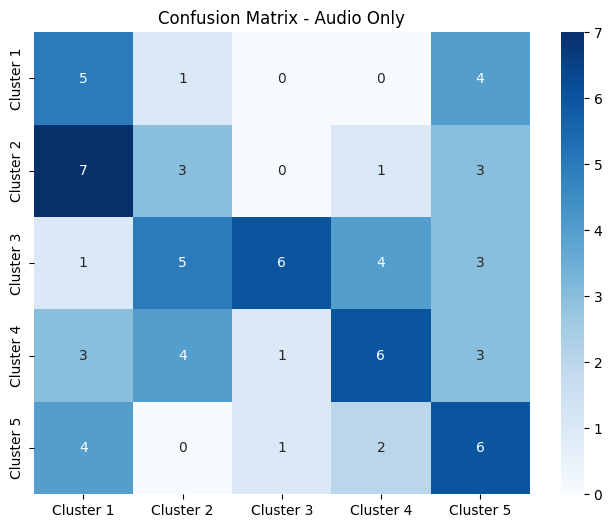

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Pastikan model dalam mode evaluasi
model.eval()
all_preds = []
all_labels = []

print("⏳ Mengevaluasi model audio (hanya data valid)...")
with torch.no_grad():
    for specs, labels in test_loader:
        specs = specs.to(device)
        outputs = model(specs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# --- SOLUSI ERROR: Filter label -1 ---
all_preds_np = np.array(all_preds)
all_labels_np = np.array(all_labels)

# Buat masker untuk mengambil data yang labelnya BUKAN -1
mask = all_labels_np != -1
valid_preds = all_preds_np[mask]
valid_labels = all_labels_np[mask]
# -------------------------------------

# 2. Hitung Akurasi pada data valid
acc = accuracy_score(valid_labels, valid_preds)
print(f"\n" + "="*30)
print(f"🎯 Akurasi Audio Valid: {acc:.4f}")
print("="*30)

# 3. Cetak Laporan (Sekarang jumlah kelas pasti 5, cocok dengan unique_labels)
print("\n📋 Laporan Klasifikasi:")
print(classification_report(valid_labels, valid_preds, target_names=unique_labels))

# 4. Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(valid_labels, valid_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix - Audio Only')
plt.show()